In [1]:
import os

import matplotlib.pyplot as plt
import cv2

import read_video

In [2]:
test_video_path = os.path.join(
    '/home/maksim/Desktop/ITMO Lectures/3. CV DL and CV',
    'Code/test _video/video 3/video_3_1.mp4'
)

In [3]:
video_frames = read_video.read_video(test_video_path, step=24)

In [4]:
video_frames.shape

(13, 720, 1280, 3)

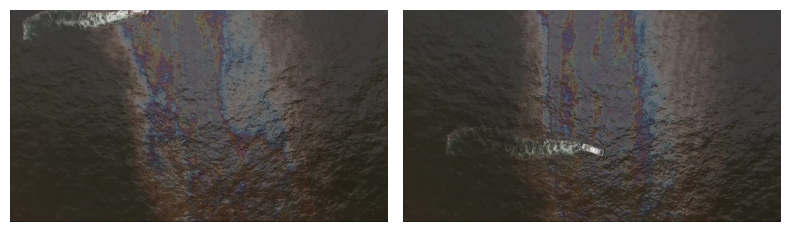

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
for ax_i, img_i in enumerate([0, -1]):
    axs[ax_i].imshow(video_frames[img_i])
    axs[ax_i].axis('off')
plt.tight_layout()
plt.show()

In [6]:
stitcher = cv2.Stitcher.create(cv2.Stitcher_SCANS)

In [7]:
status, output = stitcher.stitch(video_frames)

In [8]:
if status == 0:
    print('Images stitched successfully.')
else:
    print(f'Error status: {status}')

Images stitched successfully.


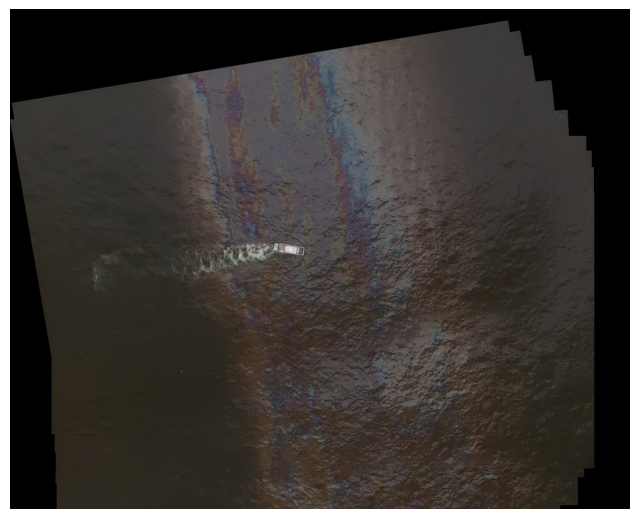

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(output)
ax.axis('off')
plt.show()